In [30]:
import yfinance as yf
import pandas as pd
import os

In [37]:
if os.path.exists("BTC_USD.csv"):
    BTC_USD = pd.read_csv("BTC_USD.csv", index_col=0)
else:
    BTC_USD = yf.Ticker("BTC-USD")
    BTC_USD = BTC_USD.history(period="max")
    BTC_USD.to_csv("BTC_USD.csv")

In [38]:
BTC_USD.index = pd.to_datetime(BTC_USD.index)

In [53]:
BTC_USD

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,424.440002,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,394.795990,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,408.903992,1
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,398.821014,0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,402.152008,1
...,...,...,...,...,...,...,...
2024-08-15 00:00:00+00:00,58733.261719,59838.648438,56161.593750,57560.097656,35682112440,58894.105469,1
2024-08-16 00:00:00+00:00,57560.273438,59847.359375,57110.019531,58894.105469,29350938673,59478.972656,1
2024-08-17 00:00:00+00:00,58893.531250,59694.667969,58814.832031,59478.972656,13589684021,58483.964844,0


<Axes: xlabel='Date'>

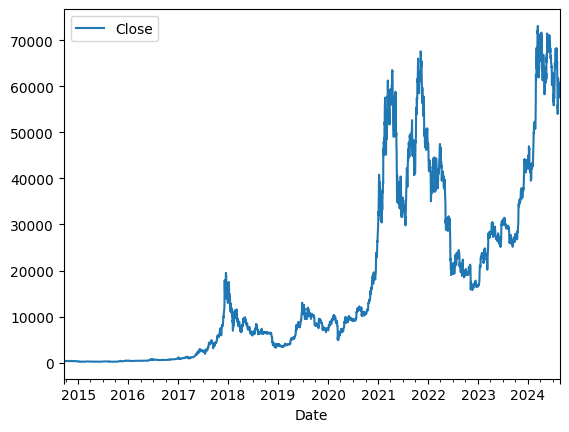

In [40]:
BTC_USD.plot.line(y="Close", use_index=True)

In [41]:
del BTC_USD["Dividends"]
del BTC_USD["Stock Splits"]

In [42]:
BTC_USD["Tomorrow"] = BTC_USD["Close"].shift(-1)

In [43]:
BTC_USD["Target"] = (BTC_USD["Tomorrow"] > BTC_USD["Close"]).astype(int)

In [44]:
BTC_USD = BTC_USD.loc["1990-01-01":].copy()

In [45]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = BTC_USD.iloc[:-100]
test = BTC_USD.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [47]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

np.float64(0.5652173913043478)

<Axes: xlabel='Date'>

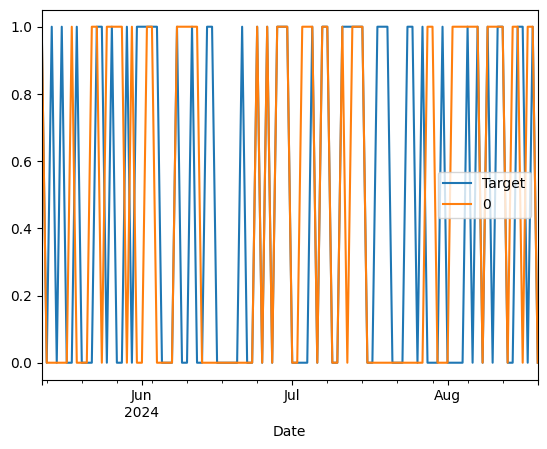

In [48]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [49]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [50]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [51]:
predictions = backtest(BTC_USD, model, predictors)

In [52]:
predictions["Predictions"].value_counts()

Predictions
0    598
1    527
Name: count, dtype: int64

In [54]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.48007590132827327)

In [55]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.505778
1    0.494222
Name: count, dtype: float64

In [56]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = BTC_USD.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    BTC_USD[ratio_column] = BTC_USD["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    BTC_USD[trend_column] = BTC_USD.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [57]:
BTC_USD = BTC_USD.dropna(subset=BTC_USD.columns[BTC_USD.columns != "Tomorrow"])

In [58]:
BTC_USD

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2017-06-13 00:00:00+00:00,2680.909912,2789.040039,2650.379883,2717.020020,1781200000,2506.370117,0,1.010674,1.0,0.963053,4.0,1.432064,45.0,2.367277,165.0,4.776714,560.0
2017-06-14 00:00:00+00:00,2716.879883,2786.830078,2412.939941,2506.370117,1696560000,2464.580078,0,0.959672,1.0,0.908840,3.0,1.305737,44.0,2.169459,164.0,4.390307,560.0
2017-06-15 00:00:00+00:00,2499.580078,2534.709961,2212.959961,2464.580078,2026259968,2518.560059,1,0.991593,0.0,0.926136,2.0,1.269834,43.0,2.119742,163.0,4.301510,560.0
2017-06-16 00:00:00+00:00,2469.570068,2539.919922,2385.149902,2518.560059,1195190016,2655.879883,1,1.010833,1.0,0.978754,2.0,1.283052,43.0,2.152088,164.0,4.379597,560.0
2017-06-17 00:00:00+00:00,2514.010010,2685.189941,2484.959961,2655.879883,1534509952,2548.290039,0,1.026538,2.0,1.032419,3.0,1.336618,43.0,2.253736,164.0,4.600330,561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-15 00:00:00+00:00,58733.261719,59838.648438,56161.593750,57560.097656,35682112440,58894.105469,1,0.989878,0.0,0.975658,2.0,0.929034,26.0,0.983713,129.0,1.569773,488.0
2024-08-16 00:00:00+00:00,57560.273438,59847.359375,57110.019531,58894.105469,29350938673,59478.972656,1,1.011455,1.0,0.997679,3.0,0.952512,27.0,1.005473,129.0,1.606189,488.0
2024-08-17 00:00:00+00:00,58893.531250,59694.667969,58814.832031,59478.972656,13589684021,58483.964844,0,1.004941,2.0,1.007162,3.0,0.963442,28.0,1.014195,130.0,1.622107,489.0


In [59]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [60]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [61]:
predictions = backtest(BTC_USD, model, new_predictors)

In [62]:
predictions["Predictions"].value_counts()

Predictions
0.0    107
1.0     18
Name: count, dtype: int64

In [63]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5555555555555556)

In [64]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.528
1    0.472
Name: count, dtype: float64

In [65]:
predictions

,Target,Predictions
Date,,
2024-04-17 00:00:00+00:00,1,1.0
2024-04-18 00:00:00+00:00,1,0.0
2024-04-19 00:00:00+00:00,1,0.0
2024-04-20 00:00:00+00:00,0,0.0
2024-04-21 00:00:00+00:00,1,0.0
...,...,...
2024-08-15 00:00:00+00:00,1,0.0
2024-08-16 00:00:00+00:00,1,0.0
2024-08-17 00:00:00+00:00,0,0.0
